# Ensemble Docking Results per protein conformation

Exploratory Data Analysis of the Ensemble docking results.
This notebook does the following:
- Jitter boxplots showing the single-conformation performance per library or per combination of libraries.
- Pair plot correlations between conformation properties.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../..')
from helper_modules.plotting_metrics import PlotMetric 
from helper_modules.run_or_load import run_or_load

## Load the available data
- This dataframe have been computed in previous notebooks.

### Protein metadata

In [2]:
DIR = '../1_Download_and_prepare_protein_ensembles'
path_to_file = f'{DIR}/TABLA_MTDATA_HSP90_296_crys_LIGS_INFO.json'
df_prot = pd.read_json(path_to_file)
df_prot.shape

(296, 14)

#### Include pocket volume information

In [3]:
DIR = '../3_Protein_Ensembles_Analysis/'
path_to_file = f'{DIR}/POVME3_results/Pocket_alignment/res_output.txt'
# Read the pocket volume results
df_pocket = pd.read_csv(path_to_file,
                        sep = '|', 
                        skiprows = 632, 
                        header = None, 
                        skipfooter = 3, 
                        engine = 'python',
                        names = ['pdb_id', 'volumen', 'surf_area'], 
                        index_col = 0)

# Include it to the main dataframe
df_pocket.index = df_prot.index
df_pocket = df_prot.merge(df_pocket, 
                          how='inner', 
                          left_index=True, 
                          right_index=True)

df_pocket.head(3)

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass,volumen,surf_area
1byq,in vivo function of hsp90 is dependent on atp ...,1998-10-28,1,A,1.50,1.0,29.098,2,"[10, 509]","[[1, 10], [224, 732]]",2,"[ADP, MG]",ADP,412.082022,2156.0,840.0
1osf,crystal structure and molecular modeling of 17...,2003-05-27,1,A,1.75,1.0,29.372,2,"[8, 509]","[[1, 8], [224, 732]]",3,"[KOS, ACY, MPD]",KOS,568.364400,2125.0,901.0
1uy6,structure-activity relationships in purine-bas...,2004-07-01,1,A,1.90,1.0,28.279,2,"[16, 509]","[[1, 16], [224, 732]]",1,[PU3],PU3,346.235000,1982.0,935.0


## Compute some extra properties

- It is an *apo* or an *holo* conformation?

In [4]:
df_pocket['Apo'] = ['holo' if i > 0 else 'apo' for i in df_pocket.NumLigs] 

# How many of each are there?
print('Number of Apo and Holo conformations:')
df_pocket['Apo'].value_counts()

Number of Apo and Holo conformations:


holo    289
apo       7
Name: Apo, dtype: int64

- Is the protein bound to other proteic entities?

In [5]:
df_pocket.Entities = pd.to_numeric(df_pocket.Entities, errors = 'coerce')
df_pocket['Single Entity'] = ['bound' if i > 1 else 'single' 
                              for i in df_pocket.Entities] 
# How many of each are there?
print('Number of `single` and `bound` crystalized conformations:')
df_pocket['Single Entity'].value_counts()

Number of `single` and `bound` crystalized conformations:


single    296
Name: Single Entity, dtype: int64

- Be sure that entries with no cocrystalized molecules have a `0` in their `Inhib_mass` column.

In [6]:
# Fill Na values inside Inhib_mass column with 0's
df_pocket['Inhib_mass'] = pd.to_numeric(
                                df_pocket['Inhib_mass']).fillna(0)

### Loading docking results

In [7]:
prot_name = 'hsp90'
file_name = './df_DkSc_results_COCRYS_DEKOIS_DUD.pkl'
df_dk_res = pd.read_pickle(file_name)

# Extract the features columns: Docking scores
X_dksc = df_dk_res.drop('activity', axis = 1)
X = X_dksc
# Extract the response variable: Activity
y = df_dk_res['activity']

#### Ratio of actives

In [8]:
# Proportion of active molecules R_2
R_a = round(y.sum() / len(y), 4)
R_a

0.1112

### Visualize the Docking performance per library

In [9]:
metric_name = 'roc_auc'
metric_kwargs = {'metric_name': metric_name}
libraries = ['DUD', 'DEKOIS', 'DUD_DEKOIS', 'DUD_DEKOIS_COCRYS']

raw_performances = []
for lib in libraries:
    df_perfs = PlotMetric(y_true = y.loc[lib.split('_')], 
               df_predictions = X.loc[lib.split('_')], 
               decreasing = True,
              ).format_metric_results(**metric_kwargs)
    raw_performances.append(df_perfs)

raw_performances_per_conf = pd.concat(
                                raw_performances, 
                                keys = [lib.replace('_', '\n')
                                        for lib in libraries], 
                                axis = 1)\
                        .droplevel(1, axis = 1)

Top ROC_AUC values
DUD                    0.835
DEKOIS                 0.691
DUD\nDEKOIS            0.738
DUD\nDEKOIS\nCOCRYS    0.618
dtype: float64


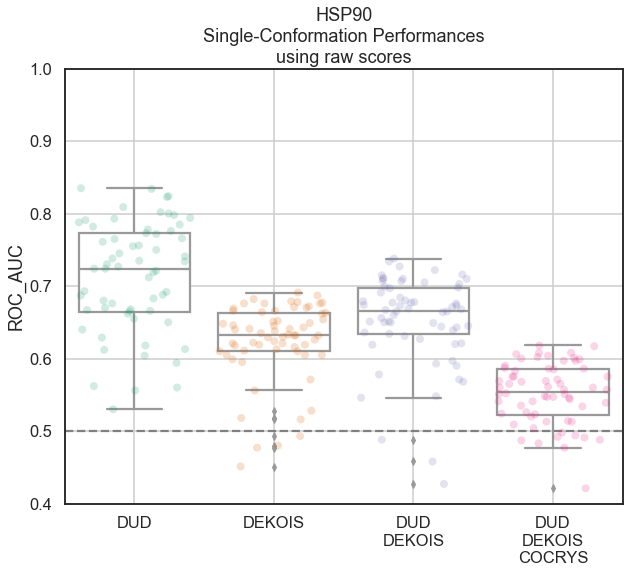

In [10]:
fig = plt.figure(figsize = (10,8))
ax = sns.stripplot(data = raw_performances_per_conf, 
                   jitter = 0.4, alpha = 0.2, size = 8)
sns.boxplot(data = raw_performances_per_conf, color = '#FFFFFFFF')
ax.set(ylim = (0.4,1), 
       title = f'{prot_name.upper()}' + 
       '\nSingle-Conformation Performances\nusing raw scores',
       ylabel = f'{metric_name.upper()}')
plt.axhline(0.5, label = 'Random', color = 'gray', ls = '--')
ax.grid()
print(f'Top {metric_name.upper()} values')
print(raw_performances_per_conf.max(axis = 0))

#### Get the individual performances (single-conformation performances)
- AUC-ROC
- Normalized Enrichment Factor

In [11]:
# AUC ROC
metric_params = {'metric_name': 'roc_auc'}
roc_auc = PlotMetric(y, X_dksc,
                        decreasing=True)\
                    .format_metric_results(rounded=5, 
                                           **metric_params)


# Normalized Enrichment Factor Ra=12
metric_params = {'metric_name': 'ef', 
                 'fraction': 0.05, 
                 'method':'normalized'}
nef_012 = PlotMetric(y, X_dksc,
                        decreasing=True)\
                    .format_metric_results(
                        rounded=5, 
                        **metric_params)

# Merge all dataframes
df_merged = df_pocket.join([roc_auc, nef_012], how='inner')

## Format and Visualize the final dataframe

In [12]:
# Rename some columns for a better visualization
last_vars = ['Resolution', 'Inhib_mass', 'volumen', 
             'surf_area', 'Apo', 'Single Entity', 
             'ROC AUC', 'EF']
new_names = ['Resolution', 'Inhib. MW', 'Pk. Volume', 
             'Pk. SASA', 'Apo', 'Single Entity', 
             'AUC-ROC', 'NEF']
df_final = df_merged[last_vars].rename(
                columns=dict(zip(last_vars, new_names)))
df_final.columns

Index(['Resolution', 'Inhib. MW', 'Pk. Volume', 'Pk. SASA', 'Apo',
       'Single Entity', 'AUC-ROC', 'NEF'],
      dtype='object')

#### Save the final dataframe for futher analysis

In [13]:
# Save the final dataframe
@run_or_load
def save_df(filename, df):
    return df

# Save it
path_to_file = f'./TABLE_Confs_Features_and_performances_{prot_name}.pkl'
df_final = save_df(path_to_file, df_final)

File loaded: ./TABLE_Confs_Features_and_performances_hsp90.pkl


### Visualize correlations among the computed properties

In [14]:
# Define some useful functions
from scipy.stats import pearsonr, spearmanr

def calculate_pvalues(df, func = spearmanr):
    ''' A simple function to compute correlation
        p-values '''
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns = df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(func(df[r], df[c])[1], 4)
    return pvalues

def corrfunc(x, y, func = spearmanr, **kwargs):
    ''' A simple function to compute correlation
        between to given variables, and visualize it using
        a pairplot figure
    '''
    r, _ = func(x, y, **kwargs)
    ax = plt.gca()
    ax.annotate(r"$\rho$ = {:.2f}".format(r), 
                fontsize=14,
                xy=(.1, .9), 
                xycoords=ax.transAxes)
    

#### Spearman correlation

In [15]:
print('Spearman correlation:')
display(df_final.corr(method='spearman'))

print('p-values:')
display(calculate_pvalues(df_final))

Spearman correlation:


,Resolution,Inhib. MW,Pk. Volume,Pk. SASA,AUC-ROC,NEF
Resolution,1.000000,-0.221507,-0.252529,-0.029920,-0.080569,-0.063850
Inhib. MW,-0.221507,1.000000,0.356229,0.358392,0.176981,0.206082
Pk. Volume,-0.252529,0.356229,1.000000,0.128054,-0.025024,-0.023579
Pk. SASA,-0.029920,0.358392,0.128054,1.000000,0.310433,0.262897
AUC-ROC,-0.080569,0.176981,-0.025024,0.310433,1.000000,0.762239
NEF,-0.063850,0.206082,-0.023579,0.262897,0.762239,1.000000


p-values:


,Resolution,Inhib. MW,Pk. Volume,Pk. SASA,AUC-ROC,NEF
Resolution,0,0.081,0.0459,0.8159,0.5302,0.6191
Inhib. MW,0.081,0,0.001,0.0065,0.272,0.1825
Pk. Volume,0.0459,0.001,0,0.2183,0.9451,0.9219
Pk. SASA,0.8159,0.0065,0.2183,0,0.0198,0.0558
AUC-ROC,0.5302,0.272,0.9451,0.0198,0,0
NEF,0.6191,0.1825,0.9219,0.0558,0,0


#### Visualize the relationship using a *pairplot*

In [ ]:
g = sns.pairplot(df_final, 
                 diag_kind = "hist", 
                 corner    = True,  
                 plot_kws = {'alpha': 0.4, 
                             's': 30, 
                             'edgecolor': 'k', 
                             'linewidth': 0})
g.map_lower(sns.kdeplot, levels = 8, 
            color = ".5", linewidths = 1)
g.map_diag(sns.kdeplot, color = '.5')
g.map_lower(corrfunc)
plt.show()

Finished!